In [3]:
import numpy as np
from numpy.typing import NDArray
import pandas as pd
from typing import Optional, Tuple, Callable, Dict, Any, Sequence

from votekit.metrics import euclidean_dist
from votekit.pref_profile import RankProfile

def spatial_profile_from_types_profile_marked_data(
    number_of_ballots: int,
    candidates: list[str],
    voter_dist: Callable[..., np.ndarray] = np.random.uniform,
    voter_dist_kwargs: Optional[Dict[str, Any]] = None,
    candidate_dist: Callable[..., np.ndarray] = np.random.uniform,
    candidate_dist_kwargs: Optional[Dict[str, Any]] = None,
    distance: Callable[[np.ndarray, np.ndarray], float] = euclidean_dist,
) -> Tuple[RankProfile, dict[str, np.ndarray], np.ndarray]:
    """
    Samples a metric position for number_of_ballots voters from
    the voter distribution. Samples a metric position for each candidate
    from the input candidate distribution. With sampled
    positions, this method then creates a ranked RankProfile in which
    voter's preferences are consistent with their distances to the candidates
    in the metric space.

    Args:
        number_of_ballots (int): The number of ballots to generate.
        by_bloc (bool): Dummy variable from parent class.

    Returns:
        Tuple[RankProfile, dict[str, numpy.ndarray], numpy.ndarray]:
            A tuple containing the preference profile object,
            a dictionary with each candidate's position in the metric
            space, and a matrix where each row is a single voter's position
            in the metric space.
    """
    if voter_dist_kwargs is None:
        if voter_dist is np.random.uniform:
            voter_dist_kwargs = {"low": 0.0, "high": 1.0, "size": 2.0}
        else:
            voter_dist_kwargs = {}

    try:
        voter_dist(**voter_dist_kwargs)
    except TypeError:
        raise TypeError("Invalid kwargs for the voter distribution.")

    if candidate_dist_kwargs is None:
        if candidate_dist is np.random.uniform:
            candidate_dist_kwargs = {"low": 0.0, "high": 1.0, "size": 2.0}
        else:
            candidate_dist_kwargs = {}

    try:
        candidate_dist(**candidate_dist_kwargs)
    except TypeError:
        raise TypeError("Invalid kwargs for the candidate distribution.")

    try:
        v = voter_dist(**voter_dist_kwargs)
        c = candidate_dist(**candidate_dist_kwargs)
        distance(v, c)
    except TypeError:
        raise TypeError(
            "Distance function is invalid or incompatible "
            "with voter/candidate distributions."
        )

    candidate_position_dict = {
        c: candidate_dist(**candidate_dist_kwargs) for c in candidates
    }

    voters = np.array(
        [voter_dist(**voter_dist_kwargs) for _ in range(number_of_ballots)]
    )
    voter_positions = np.array([v.pos for v in voters])

    ballot_pool = np.full((number_of_ballots, len(candidates)), frozenset("~"))

    for i in range(number_of_ballots):
        distance_tuples = [
            (c, distance(voter_positions[i], c_position))
            for c, c_position, in candidate_position_dict.items()
        ]
        candidate_ranking = np.array(
            [frozenset({t[0]}) for t in sorted(distance_tuples, key=lambda x: x[1])]
        )
        ballot_pool[i] = candidate_ranking

    n_candidates = len(candidates)
    df = pd.DataFrame(ballot_pool)
    df.index.name = "Ballot Index"
    df.columns = [f"Ranking_{i + 1}" for i in range(n_candidates)]
    df["Weight"] = 1
    df["Voter Set"] = [frozenset()] * len(df)
    return (
        RankProfile(
            candidates=candidates,
            df=df,
            max_ranking_length=n_candidates,
        ),
        candidate_position_dict,
        voter_positions,
    )

In [27]:
from collections import defaultdict
import matplotlib.pyplot as plt

def display_by_type(data, shape_type, color_type):
    data_sorted = defaultdict(list)
    
    for d in data:
        s = shape_type[d.identifier]
        c = color_type[d.identifier]
        data_sorted[(s,c)].append(d.pos)
    for k,v in data_sorted.items():
        plt.scatter([x[0] for x in v],[x[1] for x in v],marker=k[0],color=k[1])
    return plt.show()

In [28]:
class Voter:
    def __init__(self, pos, identifier=""):
        self.pos = pos
        self.identifier = identifier

In [29]:
import matplotlib.colors as mcolors
v = Voter((1,2),identifier="K")
shape_type = {"K": '^'}
color_type = {"K": 'b'}

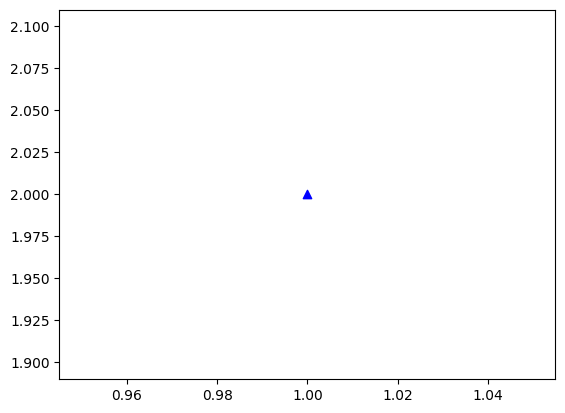

In [30]:
display_by_type([v],shape_type,color_type)